In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-Embedding-0.6B")

list_of_captions = ['Here is a sentence.', 'hello! world.']

# Tokenise a batch of captions
tokens = tokenizer(
  list_of_captions,
  padding="max_length",
  truncation=True,
  max_length=32,
  return_tensors="pt"
)

input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]

print("🔢 Input IDs:\n", input_ids)
print("\n🎭 Attention mask:\n", attention_mask)

# 🔍 View token splits and ids
for i, caption in enumerate(list_of_captions):
  print(f"Original: {caption}")
  print("Tokens:", tokenizer.tokenize(caption))
  print("Token IDs:", input_ids[i].tolist())
  print("Decoded:", tokenizer.decode(input_ids[i], skip_special_tokens=True))

print("Other info")
print("Vocab size:", tokenizer.vocab_size)



🔢 Input IDs:
 tensor([[  8420,    374,    264,  11652,     13, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643],
        [ 14990,      0,   1879,     13, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643]])

🎭 Attention mask:
 tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
Original: Here is a sentence.
Tokens: ['Here', 'Ġis', 'Ġa', 'Ġsentence', '.']
Token IDs: [8420, 374, 264, 11652, 13, 151643, 151643, 151643, 151643,

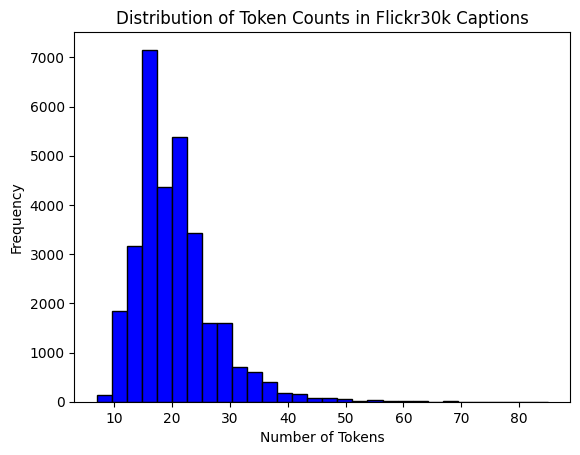

Max token length: 85


In [5]:
# Get max len and distrubtion of flickr captions
metadata_path = Path("/home/bwilliams/mlx/week4/MLX8-W4-Multimodal-TransferLearning/.ben/data/flickr30k/metadata.parquet")
df = pd.read_parquet(metadata_path)

# Tokenize each caption and count tokens
token_lengths = [len(tokenizer.tokenize(caption)) for caption in df["caption"].tolist()]

# Plot histogram
plt.hist(token_lengths, bins=30, color='blue', edgecolor='black')
plt.title("Distribution of Token Counts in Flickr30k Captions")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

# print max len
print("Max token length:", max(token_lengths))

### Now work on adding embeddings

In [9]:
from transformers import AutoTokenizer, AutoModel

# 1. Load tokenizer + model
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-Embedding-0.6B")
model = AutoModel.from_pretrained("Qwen/Qwen3-Embedding-0.6B")

In [10]:
# 2. Grab the embedding layer
embed_layer = model.get_input_embeddings()  
# This is an nn.Embedding of shape (vocab_size, hidden_size)
print("Vocab size:", embed_layer.num_embeddings)
print("Hidden size:", embed_layer.embedding_dim)

# 3. Tokenise some captions
example_data = ["Here is a sentence.", "hello world!"]
tokens = tokenizer(example_data, padding=True, truncation=True, max_length=50, return_tensors="pt")
input_ids = tokens["input_ids"]  # (batch, seq_len)

# 4. Lookup embeddings
embeddings = embed_layer(input_ids)  
# -> Tensor of shape (batch, seq_len, hidden_size)
print("Embeddings shape:", embeddings.shape)
print("Embeddings:", embeddings)




Vocab size: 151669
Hidden size: 1024
Embeddings shape: torch.Size([2, 6, 1024])
Embeddings: tensor([[[-0.0029, -0.0125, -0.0142,  ...,  0.0469,  0.0210,  0.0479],
         [ 0.0183,  0.0234, -0.0554,  ...,  0.0053,  0.0334,  0.0474],
         [-0.0240,  0.0259, -0.0601,  ...,  0.0250,  0.0088,  0.0332],
         [ 0.0170, -0.0674,  0.0131,  ...,  0.0086,  0.0210, -0.0094],
         [ 0.0066,  0.0640, -0.0623,  ..., -0.0096,  0.0074, -0.0248],
         [-0.0043,  0.0435, -0.0334,  ..., -0.0039,  0.0449,  0.0320]],

        [[-0.0391,  0.0039,  0.0175,  ...,  0.0192, -0.0349, -0.0088],
         [-0.0138, -0.0613, -0.0277,  ..., -0.0181, -0.0325, -0.0339],
         [-0.0031,  0.0327, -0.0703,  ...,  0.0138, -0.0144,  0.0128],
         [-0.0043,  0.0435, -0.0334,  ..., -0.0039,  0.0449,  0.0320],
         [-0.0043,  0.0435, -0.0334,  ..., -0.0039,  0.0449,  0.0320],
         [-0.0043,  0.0435, -0.0334,  ..., -0.0039,  0.0449,  0.0320]]],
       grad_fn=<EmbeddingBackward0>)


#### Check some outputs
- CLS is added by bert as it was originally trained on classification tasks, so it would pack a summary of the whole sentence in this token.
- SEP is a separator token, that marks end of sequence
- PAD is pad

In [11]:
# Print token IDs and their corresponding embeddings
for i, caption in enumerate(example_data):     
    print(f"\nCaption: {caption}")
    token_ids = input_ids[i].tolist()
    token_embeddings = embeddings[i]  # (seq_len, hidden_size)
    
    for token_id, emb in zip(token_ids, token_embeddings):
        token = tokenizer.decode([token_id])
        print(f"Token: {token}, ID: {token_id}, Embedding shape: {emb.shape}")


Caption: Here is a sentence.
Token: Here, ID: 8420, Embedding shape: torch.Size([1024])
Token:  is, ID: 374, Embedding shape: torch.Size([1024])
Token:  a, ID: 264, Embedding shape: torch.Size([1024])
Token:  sentence, ID: 11652, Embedding shape: torch.Size([1024])
Token: ., ID: 13, Embedding shape: torch.Size([1024])
Token: <|endoftext|>, ID: 151643, Embedding shape: torch.Size([1024])

Caption: hello world!
Token: hello, ID: 14990, Embedding shape: torch.Size([1024])
Token:  world, ID: 1879, Embedding shape: torch.Size([1024])
Token: !, ID: 0, Embedding shape: torch.Size([1024])
Token: <|endoftext|>, ID: 151643, Embedding shape: torch.Size([1024])
Token: <|endoftext|>, ID: 151643, Embedding shape: torch.Size([1024])
Token: <|endoftext|>, ID: 151643, Embedding shape: torch.Size([1024])
